In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, classification_report
import os

In [10]:
# CSVファイルのパス設定
path = "G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data"
file_name = "predictions_catboostclassifier_smotea.csv"
file_path = f"{path}/{file_name}"

# データの読み込み確認
print(f"ファイルパス: {file_path}")
if os.path.exists(file_path):
    print(f"ファイルが存在します: {file_path}")
else:
    print(f"ファイルが存在しません: {file_path}")
    print("パスを確認してください。")

# データ読み込み（カンマ区切りとして読み込む）
data = pd.read_csv(file_path)
print("データ読み込み成功！データの先頭5件:")
print(data.head())
print(f"データサイズ: {data.shape}")
print(f"カラム: {data.columns.tolist()}")

ファイルパス: G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data/predictions_catboostclassifier_smotea.csv
ファイルが存在します: G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data/predictions_catboostclassifier_smotea.csv
データ読み込み成功！データの先頭5件:
    InspectionDateAndId True_Label  True_Label01  Predicted_Label01  \
0  20240229114948_31665        mci             1                  1   
1  20240227102045_31497        mci             1                  1   
2  20240208095055_31117     intact             0                  0   
3  20240213162945_31223        mci             1                  1   
4  20240201151025_20895        mci             1                  1   

   Probability_mci  Correct  
0         0.583229    False  
1         0.580356    False  
2         0.368533    False  
3         0.716059    False  
4         0.555483    False  
データサイズ: (145, 6)
カラム: ['InspectionDateAndId', 'True_Label', 'True_Label01', 'Predicted_Label01', 'Probability_mci', 'Correct']


In [17]:
# カラム名を確認
if 'InspectionDateAndId' not in data.columns:
    print("'InspectionDateAndId'カラムが見つかりません。")
    id_columns = [col for col in data.columns if 'id' in col.lower() or 'date' in col.lower()]
    if id_columns:
        print(f"似た名前のカラムが見つかりました: {id_columns}")
        id_column = id_columns[0]
        print(f"'{id_column}'を識別子として使用します。")
    else:
        data['InspectionDateAndId'] = [f"ID_{i}" for i in range(len(data))]
        id_column = 'InspectionDateAndId'
        print("識別子カラムが見つからないため、インデックスベースのIDを作成しました。")
else:
    id_column = 'InspectionDateAndId'

# True_LabelとPredicted_Labelの検出
# 'True_Label'と'Predicted_Label01'を探す
if 'True_Label' in data.columns and 'Predicted_Label01' in data.columns:
    print("'True_Label'と'Predicted_Label01'が見つかりました。")
    
    # True_Labelが文字列で、Predicted_Labelが数値の場合
    if data['True_Label'].dtype == object and data['Predicted_Label01'].dtype in [int, float]:
        print("ラベルの型が一致していません。変換を行います...")
        
        # True_Labelの値を確認
        unique_labels = data['True_Label'].unique()
        print(f"ユニークなラベル: {unique_labels}")
        
        # 文字列ラベルを数値に変換 ('intact'→0, 'mci'→1)
        if 'True_Label01' in data.columns:
            # 既にTrue_Label01があれば使用
            true_label_col = 'True_Label01'
            print(f"'{true_label_col}'を正解ラベルとして使用します。")
        else:
            # ない場合は新しく作成
            label_map = {'intact': 0, 'mci': 1}
            data['True_Label01'] = data['True_Label'].map(label_map)
            true_label_col = 'True_Label01'
            print(f"'{true_label_col}'を作成しました（'intact'→0, 'mci'→1）。")
        
        pred_label_col = 'Predicted_Label01'
        print(f"'{pred_label_col}'を予測ラベルとして使用します。")
    else:
        # 両方が同じデータ型の場合
        true_label_col = 'True_Label'
        pred_label_col = 'Predicted_Label01'
else:
    # 一般的な検出ロジック
    label_columns = []
    pred_columns = []
    
    for col in data.columns:
        if 'true' in col.lower() or ('label' in col.lower() and 'pred' not in col.lower()):
            label_columns.append(col)
        if 'pred' in col.lower() or 'forecast' in col.lower():
            pred_columns.append(col)
    
    if not label_columns:
        print("True_Labelらしきカラムが見つかりません。")
        numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        if numeric_cols:
            true_label_col = numeric_cols[0]
            print(f"'{true_label_col}'をTrue_Labelとして使用します。")
        else:
            print("適切なTrue_Labelカラムがありません。")
    else:
        true_label_col = label_columns[0]
        print(f"'{true_label_col}'をTrue_Labelとして使用します。")
    
    if not pred_columns:
        print("Predicted_Labelらしきカラムが見つかりません。")
        numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric_cols) > 1:
            pred_label_col = numeric_cols[1]
            print(f"'{pred_label_col}'をPredicted_Labelとして使用します。")
        else:
            print("適切なPredicted_Labelカラムがありません。")
    else:
        pred_label_col = pred_columns[0]
        print(f"'{pred_label_col}'をPredicted_Labelとして使用します。")

# データ型の確認と変換
print(f"\nTrue_Label列の型: {data[true_label_col].dtype}")
print(f"Predicted_Label列の型: {data[pred_label_col].dtype}")

# データ型の不一致がある場合は変換
if data[true_label_col].dtype != data[pred_label_col].dtype:
    print("データ型が一致していません。変換を行います...")
    
    # 両方を文字列型に変換するか、両方を数値型に変換
    if data[true_label_col].dtype == object and data[pred_label_col].dtype in [int, float]:
        # True_Labelが文字列、Pred_Labelが数値の場合
        if all(x in ['intact', 'mci'] for x in data[true_label_col].unique()):
            # 文字列ラベルを数値に変換
            label_map = {'intact': 0, 'mci': 1}
            data['True_Label_Numeric'] = data[true_label_col].map(label_map)
            true_label_col = 'True_Label_Numeric'
            print("True_Labelを数値に変換しました。")
    elif data[pred_label_col].dtype == object and data[true_label_col].dtype in [int, float]:
        # Pred_Labelが文字列、True_Labelが数値の場合
        if all(x in ['intact', 'mci'] for x in data[pred_label_col].unique()):
            label_map = {'intact': 0, 'mci': 1}
            data['Pred_Label_Numeric'] = data[pred_label_col].map(label_map)
            pred_label_col = 'Pred_Label_Numeric'
            print("Predicted_Labelを数値に変換しました。")
    else:
        # 両方を文字列に変換
        data['True_Label_Str'] = data[true_label_col].astype(str)
        data['Pred_Label_Str'] = data[pred_label_col].astype(str)
        true_label_col = 'True_Label_Str'
        pred_label_col = 'Pred_Label_Str'
        print("両方のラベルを文字列に変換しました。")

print(f"\n使用するTrue_Label列: {true_label_col}")
print(f"使用するPredicted_Label列: {pred_label_col}")

# 確率列を探す
prob_columns = [col for col in data.columns if 'prob' in col.lower()]
if prob_columns:
    prob_col = prob_columns[0]
    print(f"'{prob_col}'を確率値として使用します。")
else:
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in [true_label_col, pred_label_col]]
    if numeric_cols:
        prob_col = numeric_cols[0]
        print(f"確率カラムが見つからないため、'{prob_col}'を代用します。")
    else:
        data['dummy_prob'] = 0.5
        prob_col = 'dummy_prob'
        print("確率値のカラムが見つからないため、ダミーデータを作成しました。")

# データの先頭行を確認
print("\n変換後のデータ（先頭5行）:")
print(data[[id_column, true_label_col, pred_label_col, prob_col]].head())

'True_Label'と'Predicted_Label01'が見つかりました。

True_Label列の型: object
Predicted_Label列の型: int64
データ型が一致していません。変換を行います...
両方のラベルを文字列に変換しました。

使用するTrue_Label列: True_Label_Str
使用するPredicted_Label列: Pred_Label_Str
'Probability_mci'を確率値として使用します。

変換後のデータ（先頭5行）:
    InspectionDateAndId True_Label_Str Pred_Label_Str  Probability_mci
0  20240229114948_31665            mci              1         0.583229
1  20240227102045_31497            mci              1         0.580356
2  20240208095055_31117         intact              0         0.368533
3  20240213162945_31223            mci              1         0.716059
4  20240201151025_20895            mci              1         0.555483


In [18]:
# 前処理
# 日付部分の抽出（可能な場合）
try:
    data['Date'] = data[id_column].astype(str).str.extract(r'(\d{8})')[0]
    print("日付情報の抽出に成功しました。")
except:
    # 日付抽出できない場合、データを均等に分割
    unique_values = data[id_column].nunique()
    chunks = min(10, unique_values)  # 最大10のチャンク
    data['Date'] = pd.qcut(data[id_column].rank(method='first'), chunks, labels=False).astype(str)
    print("日付抽出に失敗しました。データをグループ化します。")

# ラベルが同じ型であることを確認してから予測が正しいかどうかの列を追加
data['Correct'] = (data[true_label_col] == data[pred_label_col]).astype(int)
print(f"正解数: {data['Correct'].sum()}, 正解率: {data['Correct'].mean():.4f}")

# 結果を保存するディレクトリを作成
results_dir = os.path.join(path, "analysis_results")
os.makedirs(results_dir, exist_ok=True)
print(f"分析結果は以下のディレクトリに保存されます: {results_dir}")

日付情報の抽出に成功しました。
正解数: 0, 正解率: 0.0000
分析結果は以下のディレクトリに保存されます: G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data\analysis_results


C:\Users\岩本武\AppData\Local\Temp\ipykernel_36224\964664189.py:82: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\岩本武\AppData\Local\Temp\ipykernel_36224\964664189.py:82: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\岩本武\AppData\Local\Temp\ipykernel_36224\964664189.py:82: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\岩本武\AppData\Local\Temp\ipykernel_36224\964664189.py:82: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\岩本武\AppData\Local\Temp\ipykernel_36224\964664189.py:82: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\岩本武\AppData\Local\Temp\ipykernel_36224\964664189.py:82: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing fro

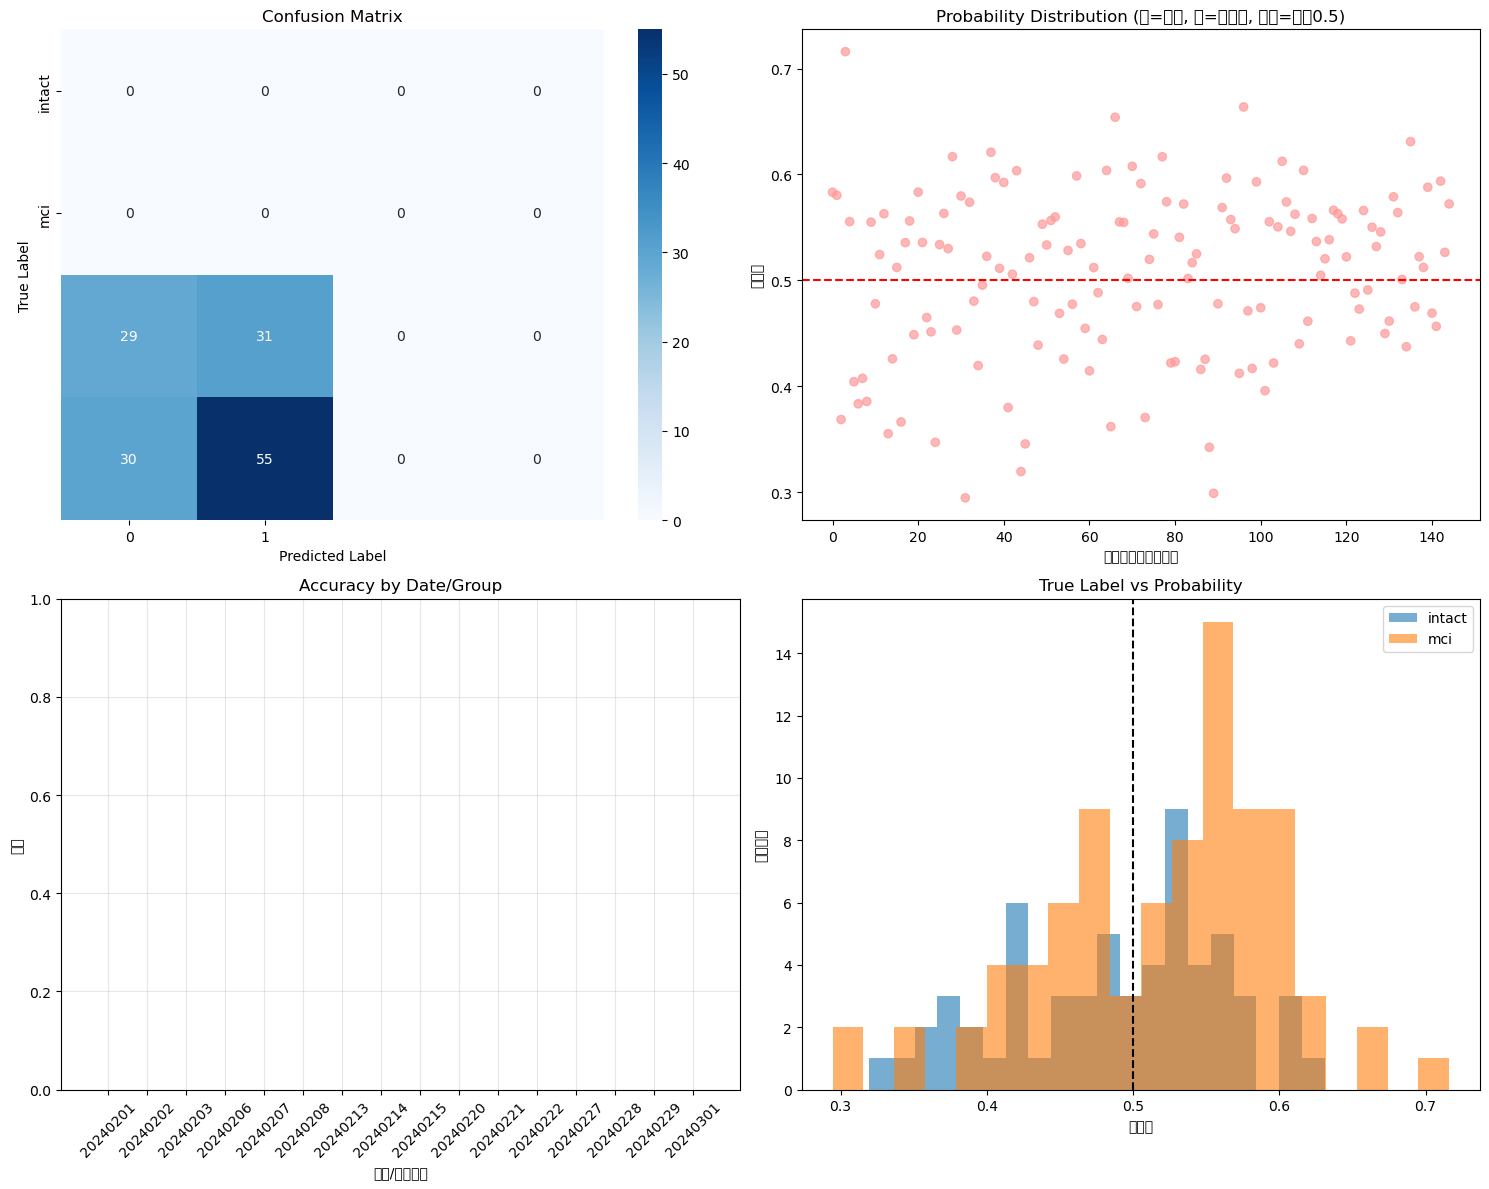

In [19]:
# 混同行列用のラベルを準備
if data[true_label_col].dtype in [int, float] and data[pred_label_col].dtype in [int, float]:
    # 数値ラベルの場合
    # True_Labelの値の種類を確認
    unique_true = sorted(data[true_label_col].unique())
    unique_pred = sorted(data[pred_label_col].unique())
    
    # ラベルが0と1の場合は'intact'と'mci'に対応
    if set(unique_true) == {0, 1} and set(unique_pred) == {0, 1}:
        xticklabels = ['Intact (0)', 'MCI (1)']
        yticklabels = ['Intact (0)', 'MCI (1)']
    else:
        xticklabels = [f'Class {i}' for i in unique_pred]
        yticklabels = [f'Class {i}' for i in unique_true]
else:
    # 文字列ラベルの場合
    xticklabels = sorted(data[pred_label_col].unique())
    yticklabels = sorted(data[true_label_col].unique())

# 図のサイズを設定
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

# 1. 混同行列
plt.subplot(2, 2, 1)
cm = confusion_matrix(data[true_label_col], data[pred_label_col])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# 2. 予測確率の分布
plt.subplot(2, 2, 2)
colors = ['#FF9999' if (t != p) else '#99FF99' 
          for t, p in zip(data[true_label_col], data[pred_label_col])]
plt.scatter(range(len(data)), data[prob_col], c=colors, alpha=0.7)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xlabel('データインデックス')
plt.ylabel('確率値')
plt.title('Probability Distribution (緑=正解, 赤=不正解, 点線=閾値0.5)')

# 3. 日付/グループごとの精度
plt.subplot(2, 2, 3)
date_accuracy = data.groupby('Date')['Correct'].mean().reset_index()

plt.bar(date_accuracy['Date'], date_accuracy['Correct'], color='blue')
plt.xlabel('日付/グループ')
plt.ylabel('精度')
plt.title('Accuracy by Date/Group')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 4. 確率値と実際のラベルの関係
plt.subplot(2, 2, 4)

# 数値ラベルの場合
if data[true_label_col].dtype in [int, float]:
    class_0_data = data[data[true_label_col] == 0][prob_col]
    class_1_data = data[data[true_label_col] == 1][prob_col]
    
    if not class_0_data.empty and not class_1_data.empty:
        plt.hist([class_0_data, class_1_data], bins=20, alpha=0.6, 
                color=['blue', 'red'], label=['Intact/Class 0', 'MCI/Class 1'])
    elif not class_0_data.empty:
        plt.hist(class_0_data, bins=20, alpha=0.6, color='blue', label='Intact/Class 0')
    elif not class_1_data.empty:
        plt.hist(class_1_data, bins=20, alpha=0.6, color='red', label='MCI/Class 1')
else:
    # 文字列ラベルの場合、各クラスごとにデータを集める
    for i, label in enumerate(sorted(data[true_label_col].unique())):
        label_data = data[data[true_label_col] == label][prob_col]
        plt.hist(label_data, bins=20, alpha=0.6, label=f'{label}')

plt.axvline(x=0.5, color='black', linestyle='--')
plt.xlabel('確率値')
plt.ylabel('データ数')
plt.title('True Label vs Probability')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(results_dir, 'prediction_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# 8. 分類レポート
try:
    # ラベルの種類を確認
    if data[true_label_col].dtype in [int, float] and set(data[true_label_col].unique()) == {0, 1}:
        target_names = ['Intact', 'MCI'] 
    else:
        target_names = [str(label) for label in sorted(data[true_label_col].unique())]
    
    report = classification_report(data[true_label_col], data[pred_label_col], 
                                target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    print("\n分類レポート:")
    print(report_df.round(3))
    report_df.to_csv(os.path.join(results_dir, 'classification_report.csv'))
except Exception as e:
    print(f"分類レポートの作成中にエラーが発生しました: {e}")
    print("代わりに基本的な指標を計算します。")
    
    # 基本的な指標を計算
    accuracy = (data[true_label_col] == data[pred_label_col]).mean()
    print(f"精度 (Accuracy): {accuracy:.4f}")
    
    # データを保存
    data[[id_column, true_label_col, pred_label_col, prob_col, 'Correct']].to_csv(
        os.path.join(results_dir, 'inspection_results.csv'), index=False)

分類レポートの作成中にエラーが発生しました: Number of classes, 4, does not match size of target_names, 2. Try specifying the labels parameter
代わりに基本的な指標を計算します。
精度 (Accuracy): 0.0000


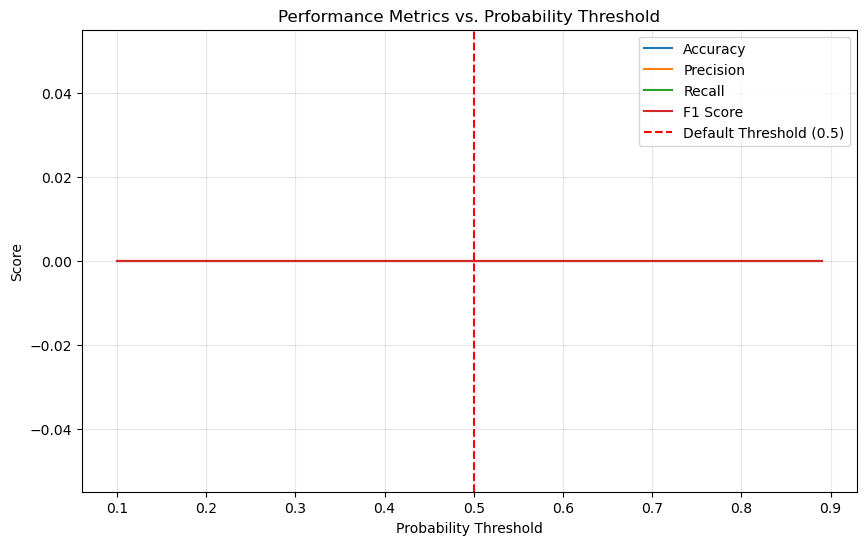

In [21]:
# 8. 分類レポート
try:
    # ラベルの種類を確認
    if data[true_label_col].dtype in [int, float] and set(data[true_label_col].unique()) == {0, 1}:
        target_names = ['Intact', 'MCI'] 
    else:
        target_names = [str(label) for label in sorted(data[true_label_col].unique())]
    
    report = classification_report(data[true_label_col], data[pred_label_col], 
                                target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    print("\n分類レポート:")
    print(report_df.round(3))
    report_df.to_csv(os.path.join(results_dir, 'classification_report.csv'))
except Exception as e:
    print(f"分類レポートの作成中にエラーが発生しました: {e}")
    print("代わりに基本的な指標を計算します。")
    
    # 基本的な指標を計算
    accuracy = (data[true_label_col] == data[pred_label_col]).mean()
    print(f"精度 (Accuracy): {accuracy:.4f}")
    
    # データを保存
    data[[id_column, true_label_col, pred_label_col, prob_col, 'Correct']].to_csv(
        os.path.join(results_dir, 'inspection_results.csv'), index=False)

分類レポートの作成中にエラーが発生しました: Number of classes, 4, does not match size of target_names, 2. Try specifying the labels parameter
代わりに基本的な指標を計算します。
精度 (Accuracy): 0.0000
